In [1]:
import pandas as pd
import numpy as np
import os
import time
import collections

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # also improves the look of plots

import math    #we need it for infinity number in dijkstra
import networkx as nx    #this is for node visualisation
from matplotlib.patches import FancyArrowPatch, Circle #we are changing library to create a curved nodes
import itertools
import operator
from itertools import permutations

In [2]:
"""
All of the functions listed below are needed to run the code



"""

'\nAll of the functions listed below are needed to run the code\n\n\n\n'

In [3]:
sns.set()  # set Seaborn defaults
plt.rcParams['figure.figsize'] = 10, 5  # default hor./vert. size of plots, in inches
plt.rcParams['lines.markeredgewidth'] = 1  # to fix issue with seaborn box plots; needed after import seaborn

os.getcwd()

wholeDataset = pd.read_csv('C:/Users/Kacper/Desktop/University/Visualisation/Group/all_passes.csv')
wholeDataset[['start_x','end_x']] = wholeDataset[['start_x','end_x']]/100 * 68 # transofrming x coordinates to width in m
wholeDataset[['start_y','end_y']] = wholeDataset[['start_y','end_y']]/100 * 105 # transofrming x coordinates to width in m
wholeDataset.drop(['a','injurytime_play', 'through_ball', 'throw_ins'], axis = 1, inplace = True)

In [4]:
def make_division(pitch_width, pitch_length, divideByX, divideByY):
    """Creates a list of divideByX*divideByY nested lists that set up the bounaries of the different parts of the pitch"""
    div = []
    step_width = pitch_width/divideByX
    step_height = pitch_length/divideByY
    for i in range (0,divideByY):
        for k in range(0,divideByX):
            div.append([k*step_width,(k+1)*step_width, i*step_height, (i+1)*step_height ]) #format [start_x, end_x, start_y, end_y]
    return div

In [5]:
def compare_to_part(x,y, pitch_devisions):
    #print("going_in",x,y)
    for i in range (len(pitch_devisions)):
        if ((pitch_devisions[i][0] <= x <= pitch_devisions[i][1]) & (pitch_devisions[i][2] <= y <= pitch_devisions[i][3])):
            return i+1

In [6]:
def create_div_cols(pitch_devisions, data):
    """ Adds columns saying what part of the pitch the pass originated from and to which part of the pitch the pass went"""
    data1 = data.copy()

    data1['part_of_origin'] = data1.apply(lambda row: compare_to_part(row['start_x'], row['start_y'], pitch_devisions), axis = 1)
    data1['part_of_dest'] = data1.apply(lambda row: compare_to_part(row['end_x'], row['end_y'], pitch_devisions), axis = 1)

    return data1

In [7]:
def create_pivot(data, start_time, end_time):
    start = min(data['secs'])*start_time
    end = max(data['secs'])*end_time
    data = data[(start<data['secs']) & (data['secs']<end)].copy()
    part_to_part_count = data.groupby(['part_of_origin', 'part_of_dest']).aggregate(['count'])['action_type']
    part_to_part_count = part_to_part_count.reset_index()
    pivot_table = part_to_part_count.pivot('part_of_origin', 'part_of_dest','count')
    return pivot_table

In [8]:
#all the stuff needed to run later code, I used Błażej and Emilyans code to do it, all of the previous functions are theirs

divideByX = 3
divideByY = 4
data = wholeDataset[wholeDataset['match_id'] == 30695]
pitch_devisions = make_division(68,105,divideByX,divideByY)
start_x = data['start_x'][0]
start_y = data['start_y'][0]
data_no_pitch_part = wholeDataset[wholeDataset['match_id'] == 30695]
data = create_div_cols(pitch_devisions, data_no_pitch_part).copy()
pivot_table = create_pivot(data, 0, 100)

#here I added some small data transforation which will be helpful for my functions

x = pd.DataFrame(pivot_table)
dict_1 = x.to_dict()       
list_1 = [(i,p,dict_1[i][p]) for i in range(1,divideByX*divideByY+1) for p in range(1,divideByX*divideByY+1) if dict_1[i][p] > 0]
#this is just positions layout for nodes
dict_3 = {1:(8,0), 2:(13,0), 3:(18,3), 4:(21,8), 5:(21,13), 6:(18,18), 7:(13,21), 8:(8,21), 9:(3,18), 10:(0,13), 11:(0,8), 12:(3,3)}

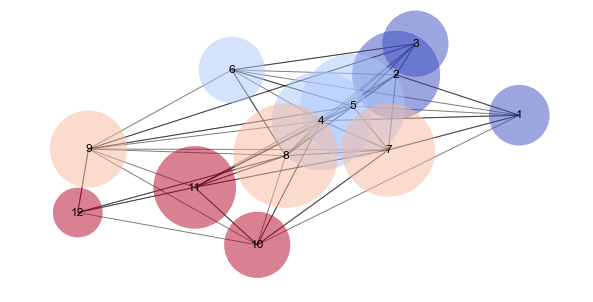

In [9]:
def A_generalized_graph(all_edges, divideByX, divideByY, nodesize, all_edges_color, color_type, edges_fading):
    
    Dg = nx.DiGraph()
    Dg.add_weighted_edges_from(all_edges)
    
    degree = nx.degree(Dg)    #code to make nodes sizes dependent on weights
    degree = collections.OrderedDict(sorted(degree.items()))
    degree_pre_list = []
    for i in degree.values():    #code to get the values from keys in dictionary
        degree_pre_list.append(i)
    degree_list = [degree_pre_list[i:i + divideByX] for i in range(0, len(degree_pre_list), divideByX)]
    
    node_pre_list = [i for i in range(1, divideByX*divideByY+1)]
    node_list = [node_pre_list[i:i + divideByX] for i in range(0, len(node_pre_list), divideByX)]
    
    pos=nx.spring_layout(Dg, pos=dict_3)
    
    for i in range(divideByY):
        nx.draw_networkx_nodes(Dg, pos, with_labels=True, nodelist=node_list[i],
                               node_size=[v * v *nodesize for v in degree_list[i]], node_color=[float(i+1) for p in range(divideByX)], 
                               alpha=edges_fading, cmap=color_type, vmin=1.0, vmax=float(divideByY))
        
    nx.draw_networkx_edges(Dg, pos, arrows=False, edge_color=all_edges_color,
                           alpha=edges_fading)
    
    nx.draw_networkx_labels(Dg, pos)
    
    plt.axis('off')

A_generalized_graph(list_1, divideByX, divideByY, 30, 'black', plt.cm.coolwarm, 0.5)

#the only stil accuring problem is that we are using a pre-made dictionary to made the positions (dict_3),
#after changing it everything should be fine

In [10]:
def Maybe(graph, start, end, start_layer, end_layer, divideByX):
    temp_1 = []
    for q in [(0+w*divideByX) for w in range(start_layer, end_layer-1) if (w+1) in graph]: # responsible for creating a number of lists  
        for i in range(divideByX**(len(graph)-3)): #responsible for creating number of combinations
            for p in range(1+q,1+q+divideByX): #responsble for creating a correct x row
                temp_1.append(p)
    temp_2 = [temp_1[i:i + divideByX**(len(graph)-2)] for i in range(0, len(temp_1), divideByX**(len(graph)-2))] #dividing the list for rows
    for i in range(len(graph)-3): #number of columns to be re-sorted
        x = 0    #starting value in a list
        y = int(len(temp_2[0])/(divideByX**i))    #till which value we are re-sorting
        for p in range(divideByX**i):    #how many times we want to re-sort
            temp_2[i][x:y] = sorted(temp_2[i][x:y])    #sorting
            x += int(len(temp_2[0])/(divideByX**i))    #for the next iterations
            y += int(len(temp_2[0])/(divideByX**i))    #for the next iterations
    temp_3 = list(zip(*temp_2))    #zipping all re-sorted lists
    if len(temp_3) == 0:
        temp_3.append((start, end))
    else:
        for i in range(len(temp_2[0])):
            temp_3[i] = (start,) + temp_3[i] + (end,)
        
    return temp_3

#this thing took me 15h to create it works in every case that came to my mind

In [11]:
def Calculator(list_key, dic):
    for i in list_key:
        temp_list = []
        counter = 0
        for q in range(len(i)-1):
            temp_list.append((i[q],i[q+1]))
        for p in temp_list:
            counter += dict_1[p[0]][p[1]]
        dic[i] = counter
        
#Allows us a quick way to calulate the paths

In [12]:
def reversed_dijkstra(graph, start, end, divideByX, divideByY):
    
    node_pre_list = [i for i in range(1, divideByX*divideByY+1)]
    node_list = [node_pre_list[i:i + divideByX] for i in range(0, len(node_pre_list), divideByX)]

    dic = {}
    for i in range(1, divideByY+1):
            dic[i] = node_list[i-1]

    start_layer = [key for key, value in dic.items() if start in value]
    end_layer = [key for key, value in dic.items() if end in value]
    both_layers = [i for i in (start_layer[0], end_layer[0])]

    list_of_layers = [i for i in range(start_layer[0], end_layer[0]+1)]
    list_for_iterations = [i for i in list_of_layers if i not in both_layers]
    list_of_iterations = [list(itertools.combinations(list_for_iterations, i)) for i in range(len(list_for_iterations)+1)]
    flat_list = [item for sublist in list_of_iterations for item in sublist]
    list_complete = [((start_layer[0],) + i + (end_layer[0],)) for i in flat_list]

    list_of_combinations = []
    length_of_paths = {}
    
    #return list_complete
    
    
    for i in list_complete:
        list_of_combinations.append(Maybe(i, start, end, start_layer[0], end_layer[0], divideByX))
    flat_combinations = [item for sublist in list_of_combinations for item in sublist]
    
    Calculator(flat_combinations, length_of_paths)
    
    print('Longest distance is ' + str(max(length_of_paths.items(), key=operator.itemgetter(1))[1]))            
    print('And the path is ' + str(max(length_of_paths.items(), key=operator.itemgetter(1))[0]))
    
    
#this combine 2 previous functions and add some more value

In [16]:
reversed_dijkstra(dict_1, 2, 11, 3, 4)

Longest distance is 64.0
And the path is (2, 5, 8, 11)
